<a href="https://colab.research.google.com/github/andrew-gerlach/small-world-hippos/blob/andrew/load_chp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Connectome Project (HCP) Dataset loader

The HCP dataset comprises resting-state and task-based fMRI from a large sample of human subjects. The NMA-curated dataset includes time series data that has been preprocessed and spatially-downsampled by aggregating within 360 regions of interest.

In [1]:
#@title Module Loading

# Check if on compute cluster
import platform
import re
if re.search("^gra\d+$", platform.node()):
  GRAHAM = True
else:
  GRAHAM = False

# Check if GPU is available
from tensorflow.python.client import device_lib
runtimes = device_lib.list_local_devices()

# Data modules
import numpy as np
if len(runtimes) > 1:
  import cupy as cp
  print("Running a GPU!")
else:
  cp = None
import pandas as pd
import nibabel as nib
from sklearn.linear_model import LinearRegression

# Plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

# Graph theory modules
import networkx as nx

# Stats modules
import scipy as sc
import statsmodels.api as sm

# QoL modules
from tqdm.notebook import tqdm #progress bar module

# python modules
import functools as func
import operator as op
import os
from collections import defaultdict
from pathlib import Path
import multiprocessing as mult


2021-07-20 23:56:50.831209: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-20 23:56:52.997992: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-20 23:56:53.021485: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-20 23:56:53.234283: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-20 23:56:53.234414: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gra1029): /proc/driver/nvidia/version doe

In [2]:
#@title Figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
if GRAHAM:
  plt.style.use(".localdata/nma.mplstyle")
else:
  plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

# Basic parameters

In [3]:
#@title Run to load basic parameters
# The download cells will store the data in nested directories starting here:
if GRAHAM:
  HCP_DIR = "./.localdata/hcp"
else:
  HCP_DIR = "./hcp"
if not os.path.isdir(HCP_DIR):
  os.mkdir(HCP_DIR)

# The data shared for NMA projects is a subset of the full HCP dataset
N_SUBJECTS = 339
# Flag for keeping tack if subjects have been adjusted
subj_adjust = False

# The data have already been aggregated into ROIs from the Glasesr parcellation
N_PARCELS = 360

# The acquisition parameters for all tasks were identical
TR = 0.72  # Time resolution, in sec

# The parcels are matched across hemispheres with the same order
HEMIS = ["Right", "Left"]

# Each experiment was repeated multiple times in each subject
N_RUNS_REST = 4
N_RUNS_TASK = 2

#NBACK number of frames per run
FRAMES_PER_RUN = 405

# Time series data are organized by experiment, with each experiment
# having an LR and RL (phase-encode direction) acquistion
BOLD_NAMES = [
  "rfMRI_REST1_LR", "rfMRI_REST1_RL",
  "rfMRI_REST2_LR", "rfMRI_REST2_RL",
  "tfMRI_MOTOR_RL", "tfMRI_MOTOR_LR",
  "tfMRI_WM_RL", "tfMRI_WM_LR",
  "tfMRI_EMOTION_RL", "tfMRI_EMOTION_LR",
  "tfMRI_GAMBLING_RL", "tfMRI_GAMBLING_LR",
  "tfMRI_LANGUAGE_RL", "tfMRI_LANGUAGE_LR",
  "tfMRI_RELATIONAL_RL", "tfMRI_RELATIONAL_LR",
  "tfMRI_SOCIAL_RL", "tfMRI_SOCIAL_LR"
]

# You may want to limit the subjects used during code development.
# This will use all subjects:
subjects = range(N_SUBJECTS)

NODES_OF_INTEREST = ["R_p9-46v", "R_IP2", "R_7Pm", "R_AVI", "L_a9-46v", "L_46", "L_AIP", "L_MI"]
NETWORKS_OF_INTEREST = networks = ['Cingulo-Oper', 'Default', 'Dorsal-atten', 'Frontopariet']

# Downloading data

The rest and task data are shared in different files, but they will unpack into the same directory structure.

Each file is fairly large and will take some time to download. If you are focusing only on rest or task analyses, you may not want to download only that dataset.

We also separately provide some potentially useful behavioral covariate information.

In [4]:
#@title Get Rest Data
if not GRAHAM:
  fname = "hcp_rest.tgz"
  if not os.path.exists(fname):
    !wget -qO $fname https://osf.io/bqp7m/download/
    !tar -xzf $fname -C $HCP_DIR --strip-components=1

In [5]:
#@title Get task data, covariates, and atlas
if not GRAHAM:
  fname = "hcp_task.tgz"
  if not os.path.exists(fname):
    !wget -qO $fname https://osf.io/s4h8j/download/
    !tar -xzf $fname -C $HCP_DIR --strip-components=1

  fname = "hcp_covariates.tgz"
  if not os.path.exists(fname):
    !wget -qO $fname https://osf.io/x5p4g/download/
    !tar -xzf $fname -C $HCP_DIR --strip-components=1

  fname = f"{HCP_DIR}/atlas.npz"
  if not os.path.exists(fname):
    !wget -qO $fname https://osf.io/j5kuc/download

## Loading region information

Downloading either dataset will create the `regions.npy` file, which contains the region name and network assignment for each parcel.

Detailed information about the name used for each region is provided [in the Supplement](https://static-content.springer.com/esm/art%3A10.1038%2Fnature18933/MediaObjects/41586_2016_BFnature18933_MOESM330_ESM.pdf) to [Glasser et al. 2016](https://www.nature.com/articles/nature18933).

Information about the network parcellation is provided in [Ji et al, 2019](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6289683/).

In [6]:
regions = np.load(f"{HCP_DIR}/regions.npy").T
region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    myelin=regions[2].astype(np.float),)

if not GRAHAM:
  # Load github directory for access to Glasser atlas file
  !git clone https://github.com/andrew-gerlach/small-world-hippos.git
  atlas_name = 'small-world-hippos/MMP_in_MNI_corr.nii'
else:
  atlas_name = 'MMP_in_MNI_corr.nii'

# Load Glasser atlas
glasser_atlas = nib.load(atlas_name)
img = glasser_atlas.get_fdata()
# Renumber to be continuous from 1 to 360 (right is 1-180, left is 201-380 in original atlas)
for i in range(201,381):
  img[img == i] = i-20
  
# Initialize storage for list of nodes in each network
unique_networks = np.unique(region_info['network'])
nNet = len(unique_networks)          # number of networks
network_regions = {}                 # initialize
for net in unique_networks:
  network_regions[net] = []

# Populate lists and extract node volume
nodeVol = np.zeros(N_PARCELS)
for i in range(N_PARCELS):
  nodeVol[i] = np.sum(img == (i+1))
  network_regions[region_info['network'][i]].append(region_info['name'][i])

with np.load(f"{HCP_DIR}/atlas.npz") as dobj:
  atlas = dict(**dobj)

/tmp/ipykernel_19412/1671069184.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  myelin=regions[2].astype(np.float),)


We also provide the [parcellation on the fsaverage5 surface](https://figshare.com/articles/HCP-MMP1_0_projected_on_fsaverage/3498446) and approximate MNI coordinates of each region, which can be useful for visualization:

# Helper functions


In [7]:
#@title GPU Utils
#@markdown Run this to prevent errors in functions that use GPU

def get_array_mod(arr):
  if cp:
    return cp.get_array_module(arr)
  else:
    return np

In [8]:
#@title Checkpointing
#@markdown Use the methods here to help create npy files to make checkpoints during pipelines

class Checkpoint:
  checkpoint_folder_name = ".checkpoints"
  def __init__(self):
    self.folder = Path(self.checkpoint_folder_name)
    if not self.folder.is_dir():
      self.folder.mkdir()

  def _file_path(self, name):
    return (self.folder / name).with_suffix('.npy')
  
  def checkpoint_exists(self, name):
    return self._file_path(name).is_file()

  def save_checkpoint(self, name, data):
    np.save(self._file_path(name), data)

  def load_checkpoint(self, name):
    if self.checkpoint_exists(name):
      return np.load(self._file_path(name), allow_pickle=True)
    else:
      return False

  def remove_checkpoint(self, name):
    p = self._file_path(name)
    if p.is_file():
      p.unlink()

In [9]:
#@title Data Loading
#@markdown Run to get functions related to data loading:
#@markdown
#@markdown ```
#@markdown load_timeseries(subject, name, runs=None, concat=True, remove_mean=True)
#@markdown load_task(name, mod=np)
#@markdown ```
def get_image_ids(name):
  """Get the 1-based image indices for runs in a given experiment.

    Args:
      name (str) : Name of experiment ("rest" or name of task) to load
    Returns:
      run_ids (list of int) : Numeric ID for experiment image files

  """
  run_ids = [
    i for i, code in enumerate(BOLD_NAMES, 1) if name.upper() in code
  ]
  if not run_ids:
    raise ValueError(f"Found no data for '{name}''")
  return run_ids

def load_timeseries(subject, name, runs=None, concat=True, remove_mean=True):
  """Load timeseries data for a single subject.
  
  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of experiment ("rest" or name of task) to load
    run (None or int or list of ints): 0-based run(s) of the task to load,
      or None to load all runs.
    concat (bool) : If True, concatenate multiple runs in time
    remove_mean (bool) : If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_tp array): Array of BOLD data values

  """
  # Get the list relative 0-based index of runs to use
  if runs is None:
    runs = range(N_RUNS_REST) if name == "rest" else range(N_RUNS_TASK)
  elif isinstance(runs, int):
    runs = [runs]

  # Get the first (1-based) run id for this experiment 
  offset = get_image_ids(name)[0]

  # Load each run's data
  bold_data = [
      load_single_timeseries(subject, offset + run, remove_mean) for run in runs
  ]

  # Optionally concatenate in time
  if concat:
    bold_data = np.concatenate(bold_data, axis=-1)

  return bold_data


def load_single_timeseries(subject, bold_run, remove_mean=True):
  """Load timeseries data for a single subject and single run.
  
  Args:
    subject (int): 0-based subject ID to load
    bold_run (int): 1-based run index, across all tasks
    remove_mean (bool): If True, subtract the parcel-wise mean

  Returns
    ts (n_parcel x n_timepoint array): Array of BOLD data values

  """
  bold_path = f"{HCP_DIR}/subjects/{subject}/timeseries"
  bold_file = f"bold{bold_run}_Atlas_MSMAll_Glasser360Cortical.npy"
  ts = np.load(f"{bold_path}/{bold_file}")
  if remove_mean:
    ts -= ts.mean(axis=1, keepdims=True)
  return ts

def load_evs(subject, name, condition):
  """Load EV (explanatory variable) data for one task condition.

  Args:
    subject (int): 0-based subject ID to load
    name (str) : Name of task
    condition (str) : Name of condition

  Returns
    evs (list of dicts): A dictionary with the onset, duration, and amplitude
      of the condition for each run.

  """
  evs = []
  for id in get_image_ids(name):
    task_key = BOLD_NAMES[id - 1]
    ev_file = f"{HCP_DIR}/subjects/{subject}/EVs/{task_key}/{condition}.txt"
    ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
    ev = dict(zip(["onset", "duration", "amplitude"], ev_array))
    evs.append(ev)
  return evs

def load_task(name, mod=np):
  """
  Load all timeseries for a given condition as a 3D numpy array:
    (n_subjects x n_parcels x n_timepoints)
  Possible conditions include "rest", "wm", etc. Can return results as either
  a numpy or cupy array

  Args:
    name (str) : Condition to 
    mod (numpy/cupy module) : Module to use for forming the array
  
  Returns:
    ts (sub x parcels x timepoints) : Array of BOLD datapoints
  """
  assert mod is np or mod is cp, "Use either numpy (np) or cupy (cp) as mod"
  if mod is cp and cp:
    return cp.array([cp.asarray(load_timeseries(subject, name)) for subject in subjects])
  return mod.array([load_timeseries(subject, name) for subject in subjects])


task = "wm"
conds = {'0bk': ["0bk_body", "0bk_faces", "0bk_places", "0bk_tools"],
         '2bk': ["2bk_body", "2bk_faces", "2bk_places", "2bk_tools"]}

N_CONDS = len(conds['2bk'])
BLOCK_FRAMES = int(27.5/TR) # 27.5s is the duration of each block

def load_wm_data(mod=np, drop=[]):
  # intialize
  ch = Checkpoint()
  if ch.checkpoint_exists('wm_data'):
    data = np.reshape(ch.load_checkpoint('wm_data'), (1,))[0]
    if mod is cp:
      for l in data:
        data[l] = cp.asarray(data[l])
    return data
  timeseries_task_wm = {}
  for l in ('0bk','2bk'):
    timeseries_task_wm[l] = []

  for subject in range(N_SUBJECTS):
    if subject in drop:
      continue

    # Load full timeseries
    timeseries = load_timeseries(subject=subject, name=task) # this is a 360, 810 numpy.ndarray
    # Extract 2back timepoints 
    for l in ('0bk','2bk'):
      evs = [load_evs(subject, task, cond) for cond in conds[l]]
      ## Notes: evs is a list of 4 (sub)lists - 1 per condition
      # Each sublist contains 2 dictionaries - 1 per run
      # Each dictionary contains onset, duration, and amplitude keys

      ts_block = np.zeros((N_PARCELS, N_CONDS*N_RUNS_TASK*BLOCK_FRAMES))
      for i in range(N_CONDS):
        for j in range(N_RUNS_TASK):
          onset_frames = int(evs[i][j]["onset"]/TR) + j*FRAMES_PER_RUN
          ts_block[:,(i*N_RUNS_TASK+j)*BLOCK_FRAMES:(i*N_RUNS_TASK+j + 1)*BLOCK_FRAMES] = timeseries[:,onset_frames:onset_frames+BLOCK_FRAMES]

      # Concat new timeseries into timeseries_task_wm_2back

      timeseries_task_wm[l].append(ts_block)

  for l in timeseries_task_wm:
    timeseries_task_wm[l] = np.array(timeseries_task_wm[l])
  ch.save_checkpoint('wm_data', timeseries_task_wm)
  if mod is cp:
    for l in timeseries_task_wm:
      timeseries_task_wm[l] = cp.asarray(timeseries_task_wm[l])
  return timeseries_task_wm
    

## Task-based analysis

In [ ]:
def condition_frames(run_evs, skip=0):
  """Identify timepoints corresponding to a given condition in each run.

  Args:
    run_evs (list of dicts) : Onset and duration of the event, per run
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    frames_list (list of 1D arrays): Flat arrays of frame indices, per run

  """
  frames_list = []
  for ev in run_evs:

    # Determine when trial starts, rounded down
    start = np.floor(ev["onset"] / TR).astype(int)

    # Use trial duration to determine how many frames to include for trial
    duration = np.ceil(ev["duration"] / TR).astype(int)

    # Take the range of frames that correspond to this specific trial
    frames = [s + np.arange(skip, d) for s, d in zip(start, duration)]

    frames_list.append(np.concatenate(frames))

  return frames_list


def selective_average(timeseries_data, ev, skip=0):
  """Take the temporal mean across frames for a given condition.

  Args:
    timeseries_data (array or list of arrays): n_parcel x n_tp arrays
    ev (dict or list of dicts): Condition timing information
    skip (int) : Ignore this many frames at the start of each trial, to account
      for hemodynamic lag

  Returns:
    avg_data (1D array): Data averagted across selected image frames based
    on condition timing

  """
  # Ensure that we have lists of the same length
  if not isinstance(timeseries_data, list):
    timeseries_data = [timeseries_data]
  if not isinstance(ev, list):
    ev = [ev]
  if len(timeseries_data) != len(ev):
    raise ValueError("Length of `timeseries_data` and `ev` must match.")

  # Identify the indices of relevant frames
  frames = condition_frames(ev, skip)

  # Select the frames from each image
  selected_data = []
  for run_data, run_frames in zip(timeseries_data, frames):
    run_frames = run_frames[run_frames < run_data.shape[1]]
    selected_data.append(run_data[:, run_frames])

  # Take the average in each parcel
  avg_data = np.concatenate(selected_data, axis=-1).mean(axis=-1)

  return avg_data

# Task analyses

Description of each task, task timing, and conditions is located [here](https://protocols.humanconnectome.org/HCP/3T/task-fMRI-protocol-details.html).

These are the condition names for each task:

```
- MOTOR: cue, lf, lh, rf, rh, t
- WM:
    0bk_body, 0bk_faces, 0bk_nir, 0bk_placed, 0bk_tools, 
    2bk_body, 2bk_faces, 2bk_nir, 2bk_placed, 2bk_tools,
    0bk_cor, 0bk_err,
    2bk_cor, 2bk_err,
    all_bk_cor, all_bk_err
- EMOTION: feat, neutral
- GAMBLING: loss, loss_event, win, win_event, neut_event
- LANGUAGE:
    cue,
    math, story
    present_math, present_story,
    question_math, question_story,
    response_math, response_story
- RELATIONAL: error, match, relation
- SOCIAL: mental_resp, mental, other_resp, rnd
```

## Load individual runs for a given task

In [ ]:
print(os.listdir(f"{HCP_DIR}/subjects/128/EVs/tfMRI_WM_RL/"))
!cat ./hcp/subjects/128/EVs/tfMRI_WM_RL/2bk_body.txt

Load working memory data for each subject

In [ ]:
task = "wm"
conds = {'0bk': ["0bk_body", "0bk_faces", "0bk_places", "0bk_tools"],
         '2bk': ["2bk_body", "2bk_faces", "2bk_places", "2bk_tools"]}

N_CONDS = len(conds['2bk'])
BLOCK_FRAMES = int(27.5/TR) # 27.5s is the duration of each block

# intialize
timeseries_task_wm = {}
for l in ('0bk','2bk'):
  timeseries_task_wm[l] = []

for subject in range(N_SUBJECTS):

  # Load full timeseries
  timeseries = load_timeseries(subject=subject, name=task) # this is a 360, 810 numpy.ndarray
  # Extract 2back timepoints 
  for l in ('0bk','2bk'):
    evs = [load_evs(subject, task, cond) for cond in conds[l]]
    ## Notes: evs is a list of 4 (sub)lists - 1 per condition
    # Each sublist contains 2 dictionaries - 1 per run
    # Each dictionary contains onset, duration, and amplitude keys

    ts_block = np.zeros((N_PARCELS, N_CONDS*N_RUNS_TASK*BLOCK_FRAMES))
    for i in range(N_CONDS):
      for j in range(N_RUNS_TASK):
        onset_frames = int(evs[i][j]["onset"]/TR) + j*FRAMES_PER_RUN
        ts_block[:,(i*N_RUNS_TASK+j)*BLOCK_FRAMES:(i*N_RUNS_TASK+j + 1)*BLOCK_FRAMES] = timeseries[:,onset_frames:onset_frames+BLOCK_FRAMES]

    # Concat new timeseries into timeseries_task_wm_2back

    timeseries_task_wm[l].append(ts_block)

## Run a simple correlation-based "functional connectivity" analysis

Generate a correlation matrix (showing "functional connectivity" or FC) for each subject and plot the group average:

In [ ]:
fc_2bk = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
fc_0bk = np.zeros((N_SUBJECTS, N_PARCELS, N_PARCELS))
for sub, ts in enumerate(timeseries_task_wm['2bk']):
  fc_2bk[sub] = np.corrcoef(ts)
for sub, ts in enumerate(timeseries_task_wm['0bk']):
  fc_0bk[sub] = np.corrcoef(ts)

group_fc_2bk = fc_2bk.mean(axis=0)
plt.imshow(group_fc_2bk, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

group_fc_0bk = fc_0bk.mean(axis=0)
plt.imshow(group_fc_0bk, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()

Threshold the correlation matrix to produce a connectome, and plot it:

In [ ]:
plotting.view_connectome(group_fc_2bk, atlas["coords"], edge_threshold="99%")

## Extract connectivity features

Function to calculate the node-wise functional connectivity summary features

In [ ]:
#returns matrix correlations between seed and target with dimensions (subjects, seed_rois, target_rois)
def extract_connectivities(seed_rois, target_rois, fc):
  fc_summary = np.zeros((len(fc),len(seed_rois),len(target_rois)))
  for i_seed in range(len(seed_rois)):
    seed_idx = region_info["name"].index(seed_rois[i_seed])
    for i_target in range(len(target_rois)):
      target_idx = region_info["name"].index(target_rois[i_target])
      if target_idx == seed_idx:
        continue 
      for i_subj in range(len(fc)):
        fc_summary[i_subj,i_seed,i_target] = fc_2bk[i_subj,seed_idx,target_idx]

  return fc_summary

In [ ]:
# Node-to-node connectivity
# Structure: array [nSubj x nNode x nNode]
nodes = ["R_p9-46v", "R_IP2", "R_7Pm", "R_AVI", "L_a9-46v", "L_46", "L_AIP", "L_MI"]
nNodes = len(nodes)
fc2bk_node2node = extract_connectivities(nodes, nodes, fc_2bk)
fc0bk_node2node = extract_connectivities(nodes, nodes, fc_0bk)

# Node-to-within-netowrk connectivity
# Structure: list [nNode], each entry is a vector [nSubj]
fc2bk_node2wnet = {}; fc0bk_node2wnet = {}
for node in nodes:
  net = region_info['network'][region_info['name'].index(node)]
  fc2bk_node2wnet[node] = np.mean(extract_connectivities([node], network_regions[net], fc_2bk), axis=2)
  fc0bk_node2wnet[node] = np.mean(extract_connectivities([node], network_regions[net], fc_0bk), axis=2)

# Node-to-other-netowrk connectivity
# Structure: list [nNode], each entry is a list [nNet <minus self>], each list is a vector [nSubj]
networks = ['Cingulo-Oper', 'Default', 'Dorsal-atten', 'Frontopariet']
nNets = len(networks)
fc2bk_node2onet = {}; fc0bk_node2onet = {}
for node in nodes:
  fc2bk_node2onet[node] = {}; fc0bk_node2onet[node] = {}
  for net in networks:
    # skip if this has already been calculated for within network connectivity
    if net == region_info['network'][region_info['name'].index(node)]:
      continue
    fc2bk_node2onet[node][net] = np.mean(extract_connectivities([node], network_regions[net], fc_2bk), axis=2)
    fc0bk_node2onet[node][net] = np.mean(extract_connectivities([node], network_regions[net], fc_0bk), axis=2)

# Node-to-whole-brain connectivity
# Structure: array [nSubj x nNode]
fc2bk_node2brain = np.mean(extract_connectivities(nodes, region_info['name'], fc_2bk), axis=2)
fc0bk_node2brain = np.mean(extract_connectivities(nodes, region_info['name'], fc_0bk), axis=2)

# Between-network and network-to-brain connectivity
# Structure: array [nSubj x nNet x nNet]
fc2bk_net2net = np.zeros((N_SUBJECTS,len(networks),len(networks)))
fc0bk_net2net = np.zeros((N_SUBJECTS,len(networks),len(networks)))
# Structure: list [nNet], each entry is a vector [nSubj]
fc2bk_net2brain = {}; fc0bk_net2brain = {}
for i, net1 in enumerate(networks):
  for j, net2 in enumerate(networks):
    fc2bk_net2net[:,i,j] = np.mean(np.mean(extract_connectivities(network_regions[net1], network_regions[net2], fc_2bk), axis=2), axis=1)
    fc0bk_net2net[:,i,j] = np.mean(np.mean(extract_connectivities(network_regions[net1], network_regions[net2], fc_0bk), axis=2), axis=1)
  fc2bk_net2brain[net1] = np.mean(np.mean(extract_connectivities(network_regions[net1], region_info['name'], fc_2bk), axis=2), axis=1)
  fc0bk_net2brain[net1] = np.mean(np.mean(extract_connectivities(network_regions[net1], region_info['name'], fc_0bk), axis=2), axis=1)

# Adjust for missing data
def adjust_fc_missing(fc0bk_node2node, fc0bk_node2wnet, fc0bk_node2onet,
                      fc0bk_node2brain, fc0bk_net2net, fc0bk_net2brain,
                      fc2bk_node2node, fc2bk_node2wnet, fc2bk_node2onet,
                      fc2bk_node2brain, fc2bk_net2net, fc2bk_net2brain,
                      missing_subjs, nodes, networks):
  fc2bk_node2node = np.delete(fc2bk_node2node, missing_subjs, axis=0)
  for node in nodes:
    fc2bk_node2wnet[node] = np.delete(fc2bk_node2wnet[node], missing_subjs)
    for net in list(fc2bk_node2onet[node].keys()):
      fc2bk_node2onet[node][net] = np.delete(fc2bk_node2onet[node][net], missing_subjs)
  fc2bk_node2brain = np.delete(fc2bk_node2brain, missing_subjs, axis=0)
  fc2bk_net2net = np.delete(fc2bk_net2net, missing_subjs, axis=0)
  for net in networks:
    fc2bk_net2brain[net] = np.delete(fc2bk_net2brain[net], missing_subjs)

  fc0bk_node2node = np.delete(fc0bk_node2node, missing_subjs, axis=0)
  for node in nodes:
    fc0bk_node2wnet[node] = np.delete(fc0bk_node2wnet[node], missing_subjs)
    for net in list(fc0bk_node2onet[node].keys()):
      fc0bk_node2onet[node][net] = np.delete(fc0bk_node2onet[node][net], missing_subjs)
  fc0bk_node2brain = np.delete(fc0bk_node2brain, missing_subjs, axis=0)
  fc0bk_net2net = np.delete(fc0bk_net2net, missing_subjs, axis=0)
  for net in networks:
    fc0bk_net2brain[net] = np.delete(fc0bk_net2brain[net], missing_subjs)
  
  return fc0bk_node2node, fc0bk_node2wnet, fc0bk_node2onet, fc0bk_node2brain, fc0bk_net2net, fc0bk_net2brain, fc2bk_node2node, fc2bk_node2wnet, fc2bk_node2onet, fc2bk_node2brain, fc2bk_net2net, fc2bk_net2brain

In [10]:
#@title Graph Thresholding
#@markdown Run this to get the thresholding functions! Main entrypoint is below, 
#@markdown use `help(graph_threshold)` for full description

#@markdown `graph_threshold(input, numSurr)`
#@markdown
#@markdown Be sure to change the runtime to gpu to speed this up as much as possible! Pass in cupy arrays rather than numpy arrays.
def graph_threshold(input, numSurr):
  """
    Thresholds FC data using fourier transform surrogates. Pass in numpy or cupy 
    array. Array must be at least 2 dimensions: the second to last must be nodes
    (e.g. atlas ROI), and the last must be the timecourse. The first
    dimension(s) may be any sort of indexing (e.g. subjects, conditions, etc). 

    Note that using cupy arrays is more than 10 times as fast as using numpy 
    arrays. Be sure to enable GPU in colab.

    Returns array of same type as input array (numpy vs cupy). Shape will 
    be the same as the input, with the exception of the last two dimensions,
    which will contain the thresholded functional connectivity graphs

    Args:
    x (numpy/cupy array of floats with at least 2 dims): data to be thresholded
    numSurr (scalar): Number of surrogates to calculate

    Returns:
    (numpy/cupy array of floats) : Functional connectivity graphs 
  """
  xp = get_array_mod(input)
  index_dims = input.shape[:-2]
  if len(index_dims) > 1:
    # We put the single number inside a tuple
    index_dims = ( func.reduce(op.mul, input.shape[:-2]) )
  elif len(index_dims) == 0:
    index_dims = ( 1, )
  # Here, if index_dims is an empty tuple, it will not contribute anything to
  # the shape (i.e. working_shape will be a 2d tuple)
  shape = (*index_dims, *input.shape[-2:])
  working_input = xp.reshape(input, shape)
  results = xp.empty((*index_dims, *corrcoef_shape(input)))
  for i, sample in enumerate(working_input):
    results[i] = surrogate_threshold(sample, numSurr)
  
  return xp.reshape(results, (*input.shape[:-2], *corrcoef_shape(input)))


def surrogate_threshold(input, numSurr, get_reject=False):
  xp = get_array_mod(input)
  assert(len(input.shape) == 2)
  fc_surr = xp.empty((numSurr, *corrcoef_shape(input)))
  for i in range(numSurr):
    surr = phase_randomize(input)
    fc_surr[i] = xp.corrcoef(surr)

  fc = xp.corrcoef(input)
  cp.cuda.Device().synchronize()

  if xp is cp:
    fc = cp.asnumpy(fc)
    fc_surr = cp.asnumpy(fc_surr)
  pvals = sc.stats.mstats.ttest_1samp(fc_surr, fc, axis=0).pvalue
  reject = two_d_multipletest(pvals)
  if get_reject:
    return reject
  dropped = fc.copy()
  dropped[reject] = 0
  fc[~reject] = 0
  if xp is cp:
    fc = cp.asarray(fc)
  return fc


def two_d_multipletest(pvals, method='bonferroni'):
  reject = sm.stats.multipletests(np.reshape(pvals, -1), method=method)[0]
  return np.reshape(reject, pvals.shape)


def phase_randomize(input):
  xp = get_array_mod(input)
  f_len = input.shape[-1]
  # 1. Calculate the Fourier transform of the original signal.
  f_transform = xp.fft.fft(input, f_len, axis=-1)
  amplitudes = xp.abs(f_transform)
  # 2. Generate a vector of random phases (i.e. a random sequence of values in
  #    the range [0, 2pi]) , with length L/2 , where L is the length of the time
  #    series.
  #    In this implementation, we make phases the same length as the transform,
  #    then symmetrize the phases by setting the front half as equal to the 
  #    negative of the back half.
  phases = xp.random.uniform(-xp.pi, xp.pi, input.shape)
  phases[..., f_len//2:] = -phases[..., f_len//2:0:-1]
  phases[..., 0] = 0

  # 3. As the Fourier transform is symmetrical, to create the new phase 
  #    randomized vector, multiply the first half of F (i.e. the half
  #    corresponding to the positive frequencies) by the phases to create the
  #    first half of F_r. The remainder of F_r is then the horizontally flipped
  #    complex conjugate of the first half. 

  phases_added = amplitudes * xp.exp(1j * phases)


  # 4. Finally, the inverse Fourier transform F_r of gives the FT surrogate. 
  #    Specifying time_len (the length of our original matrix) automatically
  #    pads the input array with 2 0s in each trial (as a result of the above
  #    operations, the array has 2 fewer timepoints than our input)
  return xp.real(xp.fft.ifft(phases_added, f_len))

def corrcoef_shape(a):
  assert(len(a.shape) > 1)
  return (a.shape[-2], a.shape[-2])

def fc_filtering(matrix):
  assert type(matrix) is np.ndarray
  b, a = sc.signal.bessel(4, [0.01*2*TR, 0.1*2*TR], btype='bandpass')
  return sc.signal.filtfilt(b,a, matrix, axis=-1)

In [11]:
def plot_density_hist(matrix):
  bins = np.arange(np.sqrt(len(np.concatenate(matrix))))
  bins = (bins - np.min(bins))/np.ptp(bins)
  fig, axes = plt.subplots(1,2, figsize=(15,5))

  rawdist = sns.distplot(matrix.flatten(), bins=bins, kde=False, ax=axes[0], norm_hist=True)
  rawdist.set(xlabel='Correlation Values', ylabel = 'Density Frequency')

#   log10dist = sns.distplot(np.log10(matrix).flatten(), kde=False, ax=axes[1], norm_hist=True)
#   log10dist.set(xlabel='log(weights)')

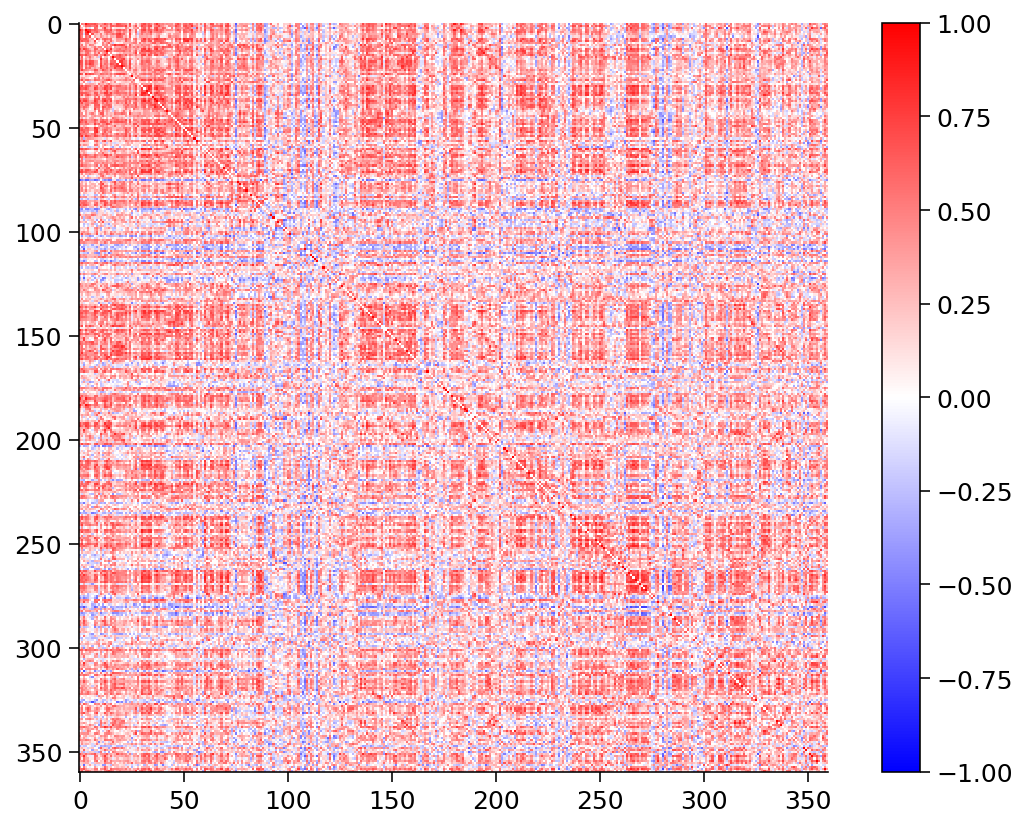

In [59]:
#wm = load_wm_data(cp)["2bk"]
series = cp.asnumpy(wm[81])
b, a = sc.signal.bessel(4, [0.01*2*TR, 0.1*2*TR], btype='bandpass')
series = cp.asarray(sc.signal.filtfilt(b,a, series, axis=1))
connectivity = cp.corrcoef(series)
connectivity = cp.asnumpy(connectivity)
connectivity = cp.asnumpy(surrogate_threshold(series, 500))
#reject = cp.asnumpy(surrogate_threshold(series, 500))
# fc_matrix = cp.asnumpy(fc_matrix)
# dropped = cp.asnumpy(dropped)
# plot_density_hist(fc_matrix)
# plot_density_hist(dropped)
# if use_node_names:
#   fc_matrix.columns = region_info["name"]
#   fc_matrix.index = region_info["name"]
#   fc_matrix = fc_matrix.sort_index(0).sort_index(0)

plt.imshow(connectivity, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
plt.colorbar()
plt.show()
# plt.imshow(reject, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
# plt.colorbar()
# plt.show()

In [23]:
ch = Checkpoint()
type(ch.load_checkpoint('wm_2bk'))

numpy.ndarray

In [21]:
hubs = np.load('.checkpoints/hubness.npy', allow_pickle=True)
hubs[0]

{'R_p9-46v': array([4.36693423e-01, 2.44465569e+00, 0.00000000e+00, 6.30512552e-04]),
 'R_IP2': array([4.61082954e-01, 2.36723672e+00, 1.71176919e-04, 5.87311478e-04]),
 'R_7Pm': array([3.34110392e-01, 2.93901943e+00, 0.00000000e+00, 7.61050780e-04]),
 'R_AVI': array([4.25695176e-01, 2.49348710e+00, 0.00000000e+00, 6.43788660e-04]),
 'L_a9-46v': array([4.74286498e-01, 2.27972706e+00, 4.66846143e-05, 5.48554627e-04]),
 'L_46': array([5.45639451e-01, 1.97628975e+00, 3.71920761e-03, 5.00430711e-04]),
 'L_AIP': array([5.06563156e-01, 2.14096074e+00, 4.51284605e-04, 5.28621718e-04]),
 'L_MI': array([3.60449635e-01, 2.86394171e+00, 0.00000000e+00, 6.54987833e-04])}

### Graph Theory

This is a work in progress :)

In [10]:
#@title Functional Connectivity
#@markdown Defines the class `FC_graph` for graph theory analysis
class FC_graph:
  """
    Class to produce functional connectivity graphs and derive metrics. Takes
    functional covariance matrix as input, along with the region names. 
    Absolutizes the connectivity strength before creating the graph.
  """
  # Nodal properties
  WEIGHT = "weight"
  STRENGTH = "strength"
  STRENGTHNORM = "strengthnorm"
  DISTANCE = "distance"
  CLOSENESS = "closeness"
  BETWEENNESS = "bw"
  PATHLENGTH = "pathlength"
  CLUSTERING = "clustering"
  
  def __init__(self, np_matrix, names):
    """
      Args:
        np_matrix (array[n,n]) : Functional covariance matrix
        names (list[n]) : Names of each of the nodes in the covariance matrix
    """
    self.data = abs(np_matrix)
    self.G = self._prepare_graph(np_matrix, region_info["name"])
    self.names = names
    self._compute_distance(self.G)

  def __len__(self):
    """
      Returns number of nodes in graph
    """
    return nx.number_of_nodes(self.G)

  def _prepare_graph(self, np_matrix, names):
    G = nx.from_numpy_matrix(np_matrix)
    G.remove_edges_from(list(nx.selfloop_edges(G)))
    return nx.relabel_nodes(G, dict(enumerate(names)))

  def _compute_distance(self, G):
    # The function accepts a argument 'distance' that, in correlation-based 
    # networks, must be seen as the inverse of the weight value. Thus, a high
    # correlation value (e.g., 0.8) means a shorter distance (i.e., 0.2).
    G_distance_dict = {(e1, e2): 1 / abs(weight) for e1, e2, weight in G.edges(data=self.WEIGHT)}

    # Then add them as attributes to the graph edges
    nx.set_edge_attributes(self.G, G_distance_dict, self.DISTANCE)

  def _compute_degree(self, G, node):
    if not nx.get_node_attributes(G, self.STRENGTH):
      strength = G.degree(weight=self.WEIGHT)
      strengths = dict(strength)
      nx.set_node_attributes(G, strengths, self.STRENGTH) # Add as nodal attribute

    if not nx.get_node_attributes(G, self.STRENGTHNORM):
      # Normalized node strength values 1/N-1
      normstrenghts = {node: val * 1/(len(G.nodes)-1) for (node, val) in strength}
      nx.set_node_attributes(G, normstrenghts, self.STRENGTHNORM)
    return nx.get_node_attributes(G, self.STRENGTHNORM)[node]

  def _compute_betweeness_centrality(self, G, node):
    betweenness = nx.get_node_attributes(G, self.BETWEENNESS)
    if betweenness and node in betweeness:
      return betweenness[node]
    betweenness = nx.betweenness_centrality(G, weight='distance', normalized=True) 
    nx.set_node_attributes(G, betweenness, 'bc')
    return betweenness[node]

  def _compute_shortest_path(self, G, node):
    path = nx.get_node_attributes(G, self.PATHLENGTH)
    if path and node in path:
      return path[node]
    path_lengths = nx.shortest_path_length(G, source=node, weight='distance')
    path_dict = { node: np.mean(list(path_lengths.values())) }
    #nx.set_node_attributes(G, path_dict, self.PATHLENGTH)
    return path_dict[node]

  def _compute_clustering(self, G, node):
    clusters = nx.get_node_attributes(G, self.CLUSTERING)
    if clusters and node in clusters:
      return clusters[node]
    clusters = nx.clustering(G, weight=self.DISTANCE, nodes=[node])
    #nx.set_node_attributes(G, clusters, self.CLUSTERING)
    return clusters[node]


  def _node_subnet(self, node):
    return dict(zip(self.names, self.networks))[node]

  def _make_subnet(self, data, names, subnet_names):
    i = np.array([name in subnet_names for name in names]).nonzero()[0]
    i_1 = np.reshape(i, (1, i.shape[0]))
    i_1 = np.repeat(i_1, i_1.shape[1], axis=0)
    i_2 = np.reshape(i, (i.shape[0], 1))
    i_2 = np.repeat(i_2, i_2.shape[0], axis=1)
    
    return FC_graph(data[i_1, i_2], subnet_names)


  # Methods to produce derivative graphs
  def get_subgraphs(self, region_info):
    """
      Returns a dict of new instances of FC_graph, each entry containing the 
      graph for the network of interest.

      Args:
        region_info (dict) : the region info dict derived from previous code blocks

      Returns:
        dict(network: FC_graph) : the subgraph containing the network of interest
    """
    network_members = defaultdict(list)
    names = region_info["name"]
    for net, name in zip(region_info["network"], names):
      network_members[net].append(name)

    return { network: self._make_subnet(self.data, names, members)
                     for network, members in network_members.items() }

  def get_sparser_graph(self, threshold):
    """
      Thresholds the connectivity based on an absolute threshold and returns
      a new graph

      Args:
        threshold (int) : Number in range [0, 1]
      
      Returns:
        FC_graph
    """
    new_matrix = self.data.copy()
    new_matrix[new_matrix<=threshold] = 0
    return FC_graph(new_matrix, self.region_info)


  # Metric methods

  def hubness(self, nodes):
    """
      Calculates four metrics that relate to the hubness of the given node:
        - Degree: The sum of the node's connections strength to all other nodes
        - Path: The average shortest path length between the node and all others
        - Betweenness Centrality: The proportion of shortest paths between every
            other node that pass through the node of interest
        - Clustering cooefficient: The proportion of the node's neighbors that are
            connected, weighted by their connection strength
      
      These metrics are returned as a dict:
      ```
      { node: np.array(degree, path length, betweenness centrality, clustering cooefficient) }
      ```

      Args:
        nodes (string, list-like) : Either a single node or a list of
          nodes to be evaluated

      Returns:
        dict(np.array) : The four hubness values
    """
    if type(nodes) is str:
      nodes = [nodes]
    assert type(nodes) in (tuple, list, np.array), "Nodes must be an iterable container"
    return { node: np.array([
      self._compute_degree(self.G, node),
      self._compute_shortest_path(self.G, node), 
      self._compute_betweeness_centrality(self.G, node), 
      self._compute_clustering(self.G, node)
    ]) for node in nodes }
  
  def small_worldness(self):
    return (nx.smallworld.sigma(self.G), nx.smallworld.omega(self.G))
    

  def mean_degree(self):
    strengths = nx.get_node_attributes(self.G, self.STRENGTHNORM).values()
    normstrengthlist = np.array(list(strengths))
    return np.sum(normstrengthlist)/len(self.G.nodes)


  # Plotting Functions

  def plot_connectome(self, use_node_names=False ):
    fc_matrix = pd.DataFrame(self.data)
    if use_node_names:
      fc_matrix.columns = region_info["name"]
      fc_matrix.index = region_info["name"]
      fc_matrix = fc_matrix.sort_index(0).sort_index(0)
    
    plt.imshow(fc_matrix, interpolation="none", cmap="bwr", vmin=-1, vmax=1)
    plt.colorbar()
    plt.show()
    

  def betweenness_centrality(self):
    betweenness = self._compute_betweeness_centrality(self.G)
    sns.distplot(list(betweenness.values()), kde=False)
    plt.xlabel('Centrality Values')
    plt.ylabel('Counts') 

In [ ]:
#@title Graph Theory Pipeline
MODULE = cp #cupy# #@param ["cp #cupy#", "np #numpy#"] {type:"raw"}
NUM_SURRUGATES = 500 #@param {type:"number"}
IGNORE_CHECKPOINTS = False #@param {type:"boolean"}
THRESHOLD_CHECKPOINT = "threshold_filtered"
HUBNESS_CHECKPOINT = "hubness-filtered"
NUM_CPUS = 32

import time

def get_graph_stats(subject):
  graph = FC_graph(subject, region_info["name"])
  stats = graph.hubness(NODES_OF_INTEREST)
  sigma, omega = graph.small_worldness()
  stats["sigma"] = sigma
  stats["omega"] = omega
  return stats
  


def graph_theory_pipeline():
  ch = Checkpoint()
  if IGNORE_CHECKPOINTS:
    ch.remove_checkpoint(THRESHOLD_CHECKPOINT)
  if not ch.checkpoint_exists(THRESHOLD_CHECKPOINT):
    data = load_wm_data(np)['2bk']
    with mult.Pool(NUM_CPUS) as pool:
      filtered = cp.array(list(pool.imap(fc_filtering, data)))
    fc = graph_threshold(filtered, NUM_SURRUGATES)
    if MODULE is cp:
      fc = cp.asnumpy(fc)
    del data
    ch.save_checkpoint(THRESHOLD_CHECKPOINT, fc)
  else:
    fc = ch.load_checkpoint(THRESHOLD_CHECKPOINT)
  d = fc[0:64]
  if not ch.checkpoint_exists(HUBNESS_CHECKPOINT):
    with mult.Pool(NUM_CPUS) as pool:
      start_time = time.process_time()
      #hubness = get_graph_stats(fc[0])
      hubness = np.array(list(tqdm(pool.imap(get_graph_stats, d ), total=len(d))))

      print(time.process_time() - start_time)
      ch.save_checkpoint(HUBNESS_CHECKPOINT + "1", hubness)
    
    with mult.Pool(NUM_CPUS) as pool:
      d = fc[64:128]
      start_time = time.process_time()
      #hubness = get_graph_stats(fc[0])
      hubness = np.array(list(tqdm(pool.imap(get_graph_stats, d ), total=len(d))))

      print(time.process_time() - start_time)
      ch.save_checkpoint(HUBNESS_CHECKPOINT + "2", hubness)
      
    with mult.Pool(NUM_CPUS) as pool:
      d = fc[128:172]
      start_time = time.process_time()
      #hubness = get_graph_stats(fc[0])
      hubness = np.array(list(tqdm(pool.imap(get_graph_stats, d ), total=len(d))))

      print(time.process_time() - start_time)
      ch.save_checkpoint(HUBNESS_CHECKPOINT + "3", hubness)
      
    with mult.Pool(NUM_CPUS) as pool:
      d = fc[172:256]
      start_time = time.process_time()
      #hubness = get_graph_stats(fc[0])
      hubness = np.array(list(tqdm(pool.imap(get_graph_stats, d ), total=len(d))))

      print(time.process_time() - start_time)
      ch.save_checkpoint(HUBNESS_CHECKPOINT + "4", hubness)
  else:
    hubness = ch.load_checkpoint(HUBNESS_CHECKPOINT)
  return hubness


graph_theory_pipeline()

  0%|          | 0/64 [00:00<?, ?it/s]

In [18]:
print(cp)

None


# Behavioral covariates


## Task performance measures

The dataset also includes aggregate behavior for each task run stored in task-specific `.csv` files. It is possible to load and work with these files using `numpy`:

In [ ]:
wm_behavior = np.genfromtxt("hcp/behavior/wm.csv",
                            delimiter=",",
                            names=True,
                            dtype=None,
                            encoding="utf")

medianRT_0bk = np.zeros(N_SUBJECTS)
medianRT_2bk = np.zeros(N_SUBJECTS)
# Pull data manually to avoid confusion with missing subjects
for i in range(N_SUBJECTS):
  tmp0 = np.zeros(N_CONDS*N_RUNS_TASK)
  tmp2 = np.zeros(N_CONDS*N_RUNS_TASK)
  idx = 0
  for k in (0,1):
    for l in ("BODY","FACE","TOOL","PLACE"):
      cond0 = "0BK_"+l
      cond2 = "2BK_"+l
      idx0 = np.logical_and(wm_behavior['Subject'] == i, wm_behavior['Run'] == k)
      idx2 = np.logical_and(idx0, wm_behavior['ConditionName'] == cond2)
      idx0 = np.logical_and(idx0, wm_behavior['ConditionName'] == cond0)
      if np.sum(idx0) > 0:
        tmp0[idx] = wm_behavior['MEDIAN_RT'][np.where(idx0 == True)]
      if np.sum(idx2) > 0:
        tmp2[idx] = wm_behavior['MEDIAN_RT'][np.where(idx2 == True)]
      idx = idx+1
  if tmp0.min() > 0:
    medianRT_0bk[i] = np.mean(tmp0)
  else:
    medianRT_0bk[i] = float('nan')
  if tmp2.min() > 0:
    medianRT_2bk[i] = np.mean(tmp2)
  else:
    medianRT_2bk[i] = float('nan')
missing_subjs = np.where(np.logical_and(np.isnan(medianRT_0bk), np.isnan(medianRT_2bk)))
missing_subjs = missing_subjs[0]
N_SUBJ_ADJ = N_SUBJECTS-len(missing_subjs)
medianRT_0bk = np.delete(medianRT_0bk, missing_subjs)
medianRT_2bk = np.delete(medianRT_2bk, missing_subjs)
if subj_adjust == False:
  print('WARNINGS: FC DATA DELETED FOR MISSING SUBJECTS!')
  fc0bk_node2node, fc0bk_node2wnet, fc0bk_node2onet, fc0bk_node2brain, fc0bk_net2net, fc0bk_net2brain, fc2bk_node2node, fc2bk_node2wnet, fc2bk_node2onet, fc2bk_node2brain, fc2bk_net2net, fc2bk_net2brain = adjust_fc_missing(fc0bk_node2node, fc0bk_node2wnet, fc0bk_node2onet,
                      fc0bk_node2brain, fc0bk_net2net, fc0bk_net2brain,
                      fc2bk_node2node, fc2bk_node2wnet, fc2bk_node2onet,
                      fc2bk_node2brain, fc2bk_net2net, fc2bk_net2brain,
                      missing_subjs, nodes, networks)
  subj_adjust = True

# Make separate dataframes for 0 and 2 back performance measures
back0_array = (wm_behavior[np.where((wm_behavior["ConditionName"] == "0BK_BODY") | (wm_behavior["ConditionName"] == "0BK_FACE") | (wm_behavior["ConditionName"] == "0BK_TOOL") | (wm_behavior["ConditionName"] == "0BK_PLACE"))])
back2_array = (wm_behavior[np.where((wm_behavior["ConditionName"] == "2BK_BODY") | (wm_behavior["ConditionName"] == "2BK_FACE") | (wm_behavior["ConditionName"] == "2BK_TOOL") | (wm_behavior["ConditionName"] == "2BK_PLACE"))])

back0_df = pd.DataFrame(back0_array)
back2_df = pd.DataFrame(back2_array)

# Make dataframes with 1 performance score per subject (averaged across runs)
back0_mean = back0_df.groupby('Subject').mean()
back2_mean = back2_df.groupby('Subject').mean()
back0_mean = back0_mean.drop(missing_subjs[0])

# Concat 0 and 2 back dataframes
wm_behavior_byBlock = pd.concat([back0_mean, back2_mean], keys=['0back', '2back'])

# Average by subject and run
#back0_df.groupby(['Subject', 'Run']).mean()
#back2_df.groupby(['Subject', 'Run']).mean()

# Accuracy Mean and standard deviation 
print("0 back Accuracy; mean SD")
print(round(back0_mean["ACC"].mean(), 2), round(back0_mean["ACC"].std(),2 ))
print("2 back Accuracy; mean SD")
print(round(back2_mean["ACC"].mean(),2), round(back2_mean["ACC"].std(),2))

# RT Mean and standard deviation 
print("0 back MEDIAN_RT; mean SD")
print(round(back0_mean["MEDIAN_RT"].mean(), 2), round(back0_mean["MEDIAN_RT"].std(),2 ))
print("2 back MEDIAN_RT; mean SD")
print(round(back2_mean["MEDIAN_RT"].mean(), 2), round(back2_mean["MEDIAN_RT"].std(),2 ))

# Histograms
#back0_mean.hist(bins=20)
#back2_mean.hist(bins=20)
hist_acc_0 = back0_mean["ACC"].hist(bins=20, color = "blue", alpha=0.3)
hist_acc_2 = back2_mean["ACC"].hist(bins=20, color = "red", alpha=0.3)

hist_rt_0 = back0_mean["MEDIAN_RT"].hist(bins=20, color = "green", alpha=0.3)
hist_rt_2 = back2_mean["MEDIAN_RT"].hist(bins=20, color = "yellow", alpha=0.3)

But, while not formally taught as part of the course, [`pandas`](https://pandas.pydata.org/) offers more powerful tools for tabular data analysis.

In [ ]:
print(len(medianRT_2bk))

## Linear Regrssion Models in Resting State Data

In [ ]:
y = medianRT_2bk
y0 = medianRT_0bk
print(y)
print(y0)

# Measures
sse = np.zeros(6)
acc = np.zeros(6)

# Node-to-node models
# Structure: array [nNode x nNode]
mods_node2node = {}
coef_node2node = np.zeros((nNodes,nNodes))
x_tot = np.zeros((N_SUBJ_ADJ,int((nNodes*(nNodes-1))/2)+1))
k = 0
for i,node1 in enumerate(nodes):
  mods_node2node[node1] = {}
  for j,node2 in enumerate(nodes):
    if j >= i:
      continue
    x_tot[:,k] = fc2bk_node2node[:,i,j]
    x = x_tot[:,k].reshape(-1,1)
    k = k+1
    mods_node2node[node1][node2] = LinearRegression(normalize=True).fit(x, y)
    coef_node2node[i,j] = mods_node2node[node1][node2].coef_
x_tot[:,-1] = y0
mod_node2node = LinearRegression(normalize=True).fit(x_tot, y)
yhat = mod_node2node.predict(x_tot)
sse[0] = np.sum((y-yhat)**2)
mod_node2node = LinearRegression(normalize=True).fit(x_tot[0:int(N_SUBJ_ADJ/2),:], y[0:int(N_SUBJ_ADJ/2)])
yhat = mod_node2node.predict(x_tot[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ,:])
acc[0] = np.sum((y[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ]-yhat)**2)

# Node-to-within-netowrk models
# Structure: vector [nNode]
mods_node2wnet = {}
coef_node2wnet = np.zeros(nNodes)
x_tot = np.zeros((N_SUBJ_ADJ,nNodes+1))
k = 0
for i, node in enumerate(nodes):
  x_tot[:,k] = fc2bk_node2wnet[node]
  x = x_tot[:,k].reshape(-1,1)
  k = k+1
  mods_node2wnet[node] = LinearRegression(normalize=True).fit(x, y)
  coef_node2wnet[i] = mods_node2wnet[node].coef_
x_tot[:,-1] = y0
mod_node2wnet = LinearRegression(normalize=True).fit(x_tot, y)
yhat = mod_node2wnet.predict(x_tot)
sse[1] = np.sum((y-yhat)**2)
mod_node2wnet = LinearRegression(normalize=True).fit(x_tot[0:int(N_SUBJ_ADJ/2),:], y[0:int(N_SUBJ_ADJ/2)])
yhat = mod_node2wnet.predict(x_tot[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ,:])
acc[1] = np.sum((y[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ]-yhat)**2)

# Node-to-other-netowrk models
# Structure: list [nNode], each entry is a list [nNet <minus self>]
mods_node2onet = {}
coef_node2onet = {}
x_tot = np.zeros((N_SUBJ_ADJ,25+1))
k = 0
for node in nodes:
  mods_node2onet[node] = {}; coef_node2onet[node] = {}
  for net in list(fc2bk_node2onet[node].keys()):
    x_tot[:,k] = fc2bk_node2onet[node][net]
    x = x_tot[:,k].reshape(-1,1)
    k = k+1
    mods_node2onet[node][net] = LinearRegression(normalize=True).fit(x, y)
    coef_node2onet[node][net] = mods_node2onet[node][net].coef_
x_tot[:,-1] = y0
mod_node2onet = LinearRegression(normalize=True).fit(x_tot, y)
yhat = mod_node2onet.predict(x_tot)
sse[2] = np.sum((y-yhat)**2)
mod_node2onet = LinearRegression(normalize=True).fit(x_tot[0:int(N_SUBJ_ADJ/2),:], y[0:int(N_SUBJ_ADJ/2)])
yhat = mod_node2onet.predict(x_tot[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ,:])
acc[2] = np.sum((y[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ]-yhat)**2)

# Node-to-whole-brain models
# Structure: vector [nNode]
mods_node2brain = {}
coef_node2brain = np.zeros(nNodes)
x_tot = np.zeros((N_SUBJ_ADJ,nNodes+1))
k = 0
for i, node in enumerate(nodes):
  x_tot[:,k] = fc2bk_node2brain[:,i]
  x = x_tot[:,k].reshape(-1,1)
  k = k+1
  mods_node2brain[node] = LinearRegression(normalize=True).fit(x, y)
  coef_node2brain[i] = mods_node2brain[node].coef_
x_tot[:,-1] = y0
mod_node2brain = LinearRegression(normalize=True).fit(x_tot, y)
yhat = mod_node2brain.predict(x_tot)
sse[3] = np.sum((y-yhat)**2)
mod_node2brain = LinearRegression(normalize=True).fit(x_tot[0:int(N_SUBJ_ADJ/2),:], y[0:int(N_SUBJ_ADJ/2)])
yhat = mod_node2brain.predict(x_tot[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ,:])
acc[3] = np.sum((y[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ]-yhat)**2)

# Between-network models
# Structure: array [nNet x nNet]
mods_net2net = {}
coef_net2net = np.zeros((nNets,nNets))
x_tot = np.zeros((N_SUBJ_ADJ,int((nNets*(nNets-1))/2)+1))
k = 0
for i,net1 in enumerate(networks):
  mods_net2net[net1] = {}
  for j,net2 in enumerate(networks):
    if j >= i:
      continue
    x_tot[:,k] = fc2bk_net2net[:,i,j]
    x = x_tot[:,k].reshape(-1,1)
    k = k+1
    mods_net2net[net1][net2] = LinearRegression(normalize=True).fit(x, y)
    coef_net2net[i,j] = mods_net2net[net1][net2].coef_
x_tot[:,-1] = y0
mod_net2net = LinearRegression(normalize=True).fit(x_tot,y)
yhat = mod_net2net.predict(x_tot)
sse[4] = np.sum((y-yhat)**2)
mod_net2net = LinearRegression(normalize=True).fit(x_tot[0:int(N_SUBJ_ADJ/2),:], y[0:int(N_SUBJ_ADJ/2)])
yhat = mod_net2net.predict(x_tot[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ,:])
acc[4] = np.sum((y[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ]-yhat)**2)

# Network-to-brain models
# Structure: vector [nNet]
mods_net2brain = {}
coef_net2brain = np.zeros(nNet)
x_tot = np.zeros((N_SUBJ_ADJ,nNets+1))
k = 0
for i,net in enumerate(networks):
  x_tot[:,k] = fc2bk_net2brain[net]
  x = x_tot[:,k].reshape(-1,1)
  k = k+1;
  mods_net2brain[net] = LinearRegression(normalize=True).fit(x, y)
  coef_net2brain[i] = mods_net2brain[net].coef_
x_tot[:,-1] = y0
mod_net2brain = LinearRegression(normalize=True).fit(x_tot,y)
yhat = mod_net2brain.predict(x_tot)
sse[5] = np.sum((y-yhat)**2)
mod_net2brain = LinearRegression(normalize=True).fit(x_tot[0:int(N_SUBJ_ADJ/2),:], y[0:int(N_SUBJ_ADJ/2)])
yhat = mod_net2brain.predict(x_tot[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ,:])
acc[5] = np.sum((y[int(N_SUBJ_ADJ/2):N_SUBJ_ADJ]-yhat)**2)

In [ ]:
print(sse)
print(acc)
scales = ['node2node','node2wnet','node2onet','node2brain','net2net','net2brain']
x = np.arange(len(scales))
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x+0.00, sse, color = 'b', width = 0.25)
ax.bar(x+0.25, acc, color = 'r', width = 0.25)
plt.xticks(x,scales)

Node to Network Adding 0bk behavior as Covariate


In [ ]:
#add 0bk rt as covar node to CO
x1= rs_dlpfc_CO_all_mean
back0_array_clean= back0_mean.to_numpy()
x2=back0_array_clean[:,4]
x3 = x2[np.logical_not(np.isnan(x2))].reshape((336,1))
x= np.concatenate((x1, x3), axis=1)
y= back2_mean['MEDIAN_RT'].to_numpy().reshape((336,1))
model = LinearRegression().fit(x, y)
print(model.coef_)
plt.scatter(x[:,0],y) 
plt.show()


In [ ]:
#FP
x1= rs_dlpfc_FP_all_mean
back0_array_clean= back0_mean.to_numpy()
x2=back0_array_clean[:,4]
x3 = x2[np.logical_not(np.isnan(x2))].reshape((336,1))
x= np.concatenate((x1, x3), axis=1)
y= back2_mean['MEDIAN_RT'].to_numpy().reshape((336,1))
model = LinearRegression().fit(x, y)
print(model.coef_)
plt.scatter(x[:,0],y) 
plt.show()


In [ ]:
#DAN
x1= rs_dlpfc_DAN_all_mean
back0_array_clean= back0_mean.to_numpy()
x2=back0_array_clean[:,4]
x3 = x2[np.logical_not(np.isnan(x2))].reshape((336,1))
x= np.concatenate((x1, x3), axis=1)
y= back2_mean['MEDIAN_RT'].to_numpy().reshape((336,1))
model = LinearRegression().fit(x, y)
print(model.coef_)
plt.scatter(x[:,0],y) 
plt.show()


In [ ]:
#DMN
x1= rs_dlpfc_DMN_all_mean
back0_array_clean= back0_mean.to_numpy()
x2=back0_array_clean[:,4]
x3 = x2[np.logical_not(np.isnan(x2))].reshape((336,1))
x= np.concatenate((x1, x3), axis=1)
y= back2_mean['MEDIAN_RT'].to_numpy().reshape((336,1))
model = LinearRegression().fit(x, y)
print(model.coef_)
plt.scatter(x[:,0],y) 
plt.show()

## Pseudo-demographics

The NMA-distributed version of the HCP data does not contain any real demographic information. But we have created a synthetic dataset of 25 "demographic" variables based on a model trained on the original dataset to predict demographics from resting-state network organization measures:

In [ ]:
demo = np.load("hcp/pseudo_demographics.npy")
demo.shape

## Original subject IDs

The dataset also contains a key to map the ordinal subject numbers to the IDs used in the original HCP dataset:

In [ ]:
ids = np.loadtxt("hcp/orig_ids.txt")
print(ids[:8])